# Step 4: Modeling

In this notebook I take the processed wildfire data and train/evaluate a series of ML algorithms. The goal to correctly identify the most large wildfires without incorrectly classifying too many small wildfires as large. While both recall and precision are important, recall is more important. Therefore, we will use the F2 score as our evaluation metric (but also consider recall and check confusion matrices).

In previous notebooks I a) generated many environmental and weather features leveraging Google Earth Engine b) performed EDA and c) feature engineering - including transformation of features to move them closer to normal distributions.

Wildfire size prediction is challenging for three reasons: 1) large wildfires are very rare compared to small wildfires, resulting is a severe class imbalance and 2) wildfire behavior is very complex and location specific so there is a lot of noise in the data, and 3) much of wildfire behavior is caused by wind/weather conditions in the days/weeks after the fire has started. As this model is intended to be used to make predictions on wildfires when they are discovered, we can't use any variables that would not yet be available (even if we can get them for historic wildfires).

In this notebook I test the performance of a series of algorithms:
* Logistic Regression
* Random Forest
* XGBoost
* LightGBM.

Model performance is evaluated via 10-fold cross-validation using the F2 score. To address the severe class imbalance in the data, two approaches are tried for each algorithm:
* Class weighting 
* SMOTE oversampling/Random undersampling. This approach is explained in more detail below.

Hyperparameters are initially tuned using RandomSearchCV. LightGBM without over/undersampling is identified as the best performing model. This algorithm is then tuned using Optuna, a state of the art hyperparameter optimization framework. This model outperforms the other models by 10-20% with an F2 score of 0.296. The tuned model is then trained on the full training set and performance is evaluated on the the hold-out test set resulting in a test F2 score of 0.297.

In [12]:
# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [13]:
#load data processed in previous notebooks
wfs = pd.read_csv('Datasets/wfs_preprocessed.csv', index_col=0)
wfs_y =  pd.read_csv('Datasets/wfs_preprocessed_y.csv', index_col=0)

First I convert the `FIRE_SIZE_CLASS` feature into a binary categorical variable. While it would be nice to be able to predict fire size with more nuance (or predict only the very largest wildfires) due to the severe class imbalance this is this will be very difficult. Our ultimate goal is to predict if a wildfire could erupt into a large fire as it starts, a binary classification of small vs large fires is sufficient.

Per this journal article from <i>Nature</i>, wildfires of class E or higher(>300 acres) can be considered "large". I'll use this as a precedent for creating a binary target variable.

https://www.nature.com/articles/s41598-021-88131-9

In [14]:
# convert target feature to a binary variable (small vs large wildfires)
large_fire_classes = ['E','F','G']
wfs_y = wfs_y['FIRE_SIZE_CLASS'].apply(lambda t: 1 if t in large_fire_classes else 0)

Before modeling I drop a few correlated/redundant features. These were IDed during pre-processing but I waited to remove them to maintain flexibility.
`LATITUDE`, `erc`, `fm1000` have strong correlation with other variables.
`aspect`,`aspect_cat`, `DISCOVERY_MONTH`, `DISCOVERY_DOY` have been replaced with dual cyclical variables (see Feature Engineering notebook)

In [15]:
# drop correlated/redundant columns
drop_cols = ['LATITUDE', 'erc', 'fm1000', 'aspect','aspect_cat', 'DISCOVERY_MONTH', 'DISCOVERY_DOY']
wfs_subset = wfs.drop(columns=drop_cols)

#simplify categorical column names
wfs_subset = wfs_subset.rename(columns={'WHR10NAME':'WHR10', 'NA_L2NAME':'L2', 'US_L3NAME':'L3'})

### Evaluation Function
This function simplifies the process of fitting a model and then producing evaluation metrics/confusion matrix. I'll will use it to quickly generate confusion matrices for each model. Note that while this function uses a single validation set, this is NOT the hold-out/test set, which will only be used at the very end. Also, while this function does produce an F2 score, I will use the mean F2 scores from 10-fold cross validation to compare model performance.

In [16]:
def evaluate_model(model, X_t, y_t, X_v, y_v):
    
    ''' Fit model to traing data, predict and evaluate based on validation data, and produce confusion matrices. '''
        
    # fit model to training data
    model.fit(X_t,y_t)

    # predict on validation set
    y_pred = model.predict(X_v)

    # calculate other evaluation metrics
    precision = round(precision_score(y_v, y_pred),4)
    recall = round(recall_score(y_v, y_pred),4)
    f2 = round(fbeta_score(y_v, y_pred, beta=2),4)
    
    #plot confusion matrix (on validation data)
    plot_confusion_matrix(model, X_v, y_v, labels=None, sample_weight=None, normalize=None);
    
    #plot confusion matrix (on validation data)
    plot_confusion_matrix(model, X_v, y_v, labels=None, sample_weight=None, normalize='true');

    # print evaluation metrics
    print('----- EVAL METRICS -----')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F2: {f2}')

In [17]:
def get_cv_scores(gr):
    
    '''Print mean CV scores for F2 and Recall from grid result'''

    fbeta = round(gr.cv_results_['mean_test_fbeta'][gr.best_index_],4)
    recall = round(gr.cv_results_['mean_test_Recall'][gr.best_index_],4)
    print(f'F2: {fbeta}')
    print(f'Recall: {recall}')

### Grid Search Plot Function
I'll use this function below to plot grid search results in order to understand how different hyperparameters influence model performance.

In [18]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    
    '''Take grid search results and plot two parameters against mean CV scores '''
    
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title(f"Grid Search Scores vs. {name_param_1} and {name_param_2}", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=12)
    ax.set_ylabel('CV Average Score', fontsize=12)
    ax.legend(loc='lower right', bbox_to_anchor= (1.5, 0), ncol=2,
            borderaxespad=0, frameon=False)
    ax.figure.set_size_inches(10, 10)
    ax.grid('on')

### Train/Test Split

Here I split the dataset into training, validation, and a test set. Training will be used to fit different models via cross validation. Validation will be used to iteratively test the performance of various models. The test set represents completely unseen data and to prevent leakage will only be used to test model performance of the selected model at the very end.

In [19]:
# Create feature and target arrays
X = wfs_subset
y = wfs_y

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123, stratify=y)

# Split training into training_sub and validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=123, stratify=y_train)

### Dummy Model

First, a dummy model to benchmark performance against. This model predicts classes randomly according to the class ratio in the training data. F2 Score is low and ROC AUC is close to 0.5 (no predictive power). However, accuracy is misleadingly high, because there are so many small wildfires.  This underscores my decision to use the F2 as the evaluation metric. 

Performance on Validation set:
Accuracy: 0.9511
AUC: 0.5028
Recall: 0.0314
F2: 0.0311


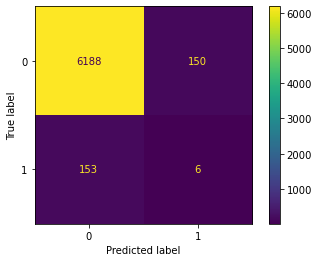

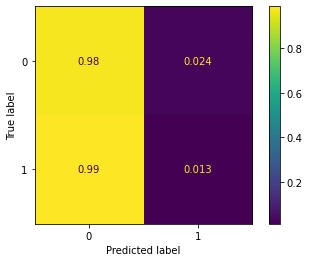

In [122]:
from sklearn.dummy import DummyClassifier

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )
scale = MinMaxScaler()

# define model
dummy = DummyClassifier('stratified')
steps = [('encode', encode), ('scale', scale), ('model', dummy)]
pipeline_dummy = Pipeline(steps=steps)

# fit it
pipeline_dummy.fit(X_train_sub,y_train_sub)

# test
y_pred = pipeline_dummy.predict(X_val)

# performance
print('Performance on Validation set:')
print(f'Accuracy: {round(accuracy_score(y_val,y_pred),4)}')
print(f'AUC: {round(roc_auc_score(y_val, y_pred),4)}')
print(f'Recall: {round(recall_score(y_val,y_pred),4)}')
print(f'F2: {round(fbeta_score(y_val, y_pred, beta=2),4)}')

plot_confusion_matrix(pipeline_dummy, X_val, y_val, labels=None, sample_weight=None, normalize=None)
plot_confusion_matrix(pipeline_dummy, X_val, y_val, labels=None, sample_weight=None, normalize='true');

### Logistic Regression

As a start I try a class weighted logistic regression. The model is successful at identifying large wildfires but misclassifies too many small wildfires to be useful.

Performance on Validation set:
Accuracy: 0.7191
AUC: 0.7487
Recall: 0.7799
F2: 0.2431


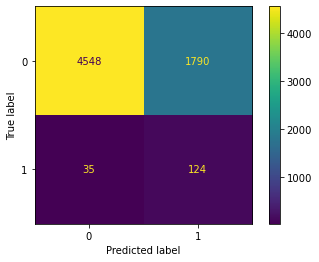

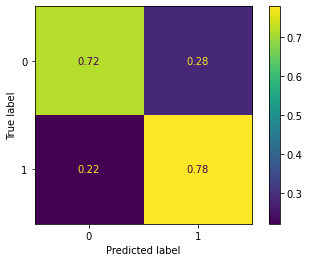

In [20]:
from sklearn.linear_model import LogisticRegression

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )
scale = MinMaxScaler()

# define model
lg1 = LogisticRegression(random_state=13, class_weight='balanced', max_iter=200)
steps = [('encode', encode), ('scale', scale), ('model', lg1)]
pipeline_lg1 = Pipeline(steps=steps)

# fit it
pipeline_lg1.fit(X_train_sub,y_train_sub)

# test
y_pred = pipeline_lg1.predict(X_val)

# performance
print('Performance on Validation set:')
print(f'Accuracy: {round(accuracy_score(y_val,y_pred),4)}')
print(f'AUC: {round(roc_auc_score(y_val, y_pred),4)}')
print(f'Recall: {round(recall_score(y_val,y_pred),4)}')
print(f'F2: {round(fbeta_score(y_val, y_pred, beta=2),4)}')
    
plot_confusion_matrix(pipeline_lg1, X_val, y_val, labels=None, sample_weight=None, normalize=None)
plot_confusion_matrix(pipeline_lg1, X_val, y_val, labels=None, sample_weight=None, normalize='true');

### Explore Optimal Tree Depth and Number of Estimators for Random Forest

I anticipate that given the prediction problem, ensemble methods will perform best. I'll start with Random Forest. One of the more important hyperparameters for Random Forest is tree depth. Here I explore optimal tree depth for a decision tree classifier. I will use this as the upper range for the tree depth hyperparameter in my grid search for the random forest classifier.

In [21]:
from sklearn.tree import DecisionTreeClassifier 

fb_scores = []
accuracy_scores = []
depth_range = list(range(1,50))

# iterate through the range of tree depths
for i in depth_range:

    # one hot encode (columns 15, 16, 17 only)
    cat_col_indeces = []
    for i,col in enumerate(X_train.columns):
        if X_train[col].dtype == 'O':
            cat_col_indeces.append(i)
    encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), cat_col_indeces)], remainder='passthrough' )

    # instantiate model
    dt_model = DecisionTreeClassifier(max_depth=i, criterion='gini')

    # define pipeline
    steps = [('encode', encode), ('model', dt_model)]
    dt_pipeline = Pipeline(steps=steps)

    # fit
    dt_pipeline.fit(X_train_sub, y_train_sub)
    
    # predict
    y_pred = dt_pipeline.predict(X_val)
    
    # caluate scores
    f2 = fbeta_score(y_val, y_pred, beta=2)
    accuracy = accuracy_score(y_val, y_pred)
    
    # save scores
    fb_scores.append(f2)
    accuracy_scores.append(accuracy)

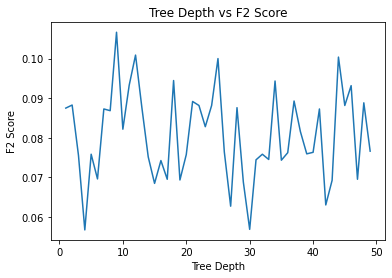

In [22]:
sns.lineplot(x=depth_range, y=fb_scores)
plt.xlabel('Tree Depth')
plt.ylabel('F2 Score')
plt.title('Tree Depth vs F2 Score');

After 20, the f2 score oscillates but does not improve substantially.

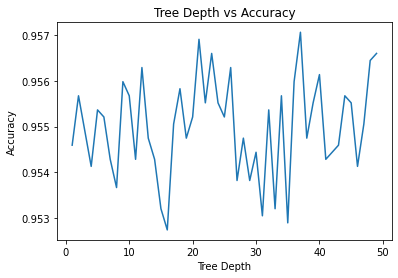

In [23]:
sns.lineplot(x=depth_range, y=accuracy_scores)
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Tree Depth vs Accuracy');

Accuracy goes down quickly with increased tree depth, quickly performing worse than a dummy model. This suggests that higher depths are resulting on overfitting. For the Random Forest model (which generally performs best with small treed depth values) I'll use 20 as my max.

Now I'll use the number of features to estimate a good start for n_estimators. For the models below I one-hot encode within a pipeline, but because I want the total number of features post-encoding, I encode outside the pipeline here:

In [24]:
#outside pipeline, we calculate number of features (post dummy-encoding)
# which we use to estimate optimal value for n_estimators

# categoricals > dummies
cat_cols = ['WHR10', 'L2','L3']
X_train_sub_dummies = X_train_sub

for col in cat_cols:
    X_train_sub_dummies = pd.get_dummies(X_train_sub_dummies, columns=[col], drop_first=True, prefix=col)
    
X_train_sub_dummies.shape[1]

44

I'll try a range around 44 for n_estimators.

### Random Forest - No Oversampling
I am first trying a random forest model because a) the data is severely imbalanced and b) the classes are very mixed. Random forest models should perform well compared to models that cannot handle class imbalance well (such as KNN) or models that have trouble with very mixed classes (SVM). 

First I will try with no upsampling or downsampling, but I will weight the classes (class_weight='balanced subsample') so that the model pays extra attention to the minority class.

In [25]:
from sklearn.ensemble import RandomForestClassifier

# define grid search/random forest function that takes a param grid as input
def GridSearch_RandomForest(param_grid):
    
    '''Carry out a grid search with 10-fold cross valididation on a random forest model given a hyperparameter grid'''
    
    #make f2 scorer
    f2_scorer = make_scorer(fbeta_score, beta=2)

    # one hot encode (columns 15, 16, 17 only)
    encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough')

    # instantiate model
    model = RandomForestClassifier(class_weight = 'balanced_subsample')

    # define pipeline
    steps = [('encode', encode), ('model', model)]
    pipeline = Pipeline(steps=steps)

    # define cross-validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

    # define grid search
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=f2_scorer)

    # execute the grid search
    grid_result = grid.fit(X_train_sub, y_train_sub)

    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    return grid_result

`n_estimators` and `max_depth` are likely to influence model performance most because they control complexity. We will tune them first.
<br/> For `n_estimators` we have estimated 44 as the optimal number and select a few higher/lower values to test.
<br/> For `max_depth` we have estimated that 20 is the max (see decision tree above) and will test all values below that.

In [26]:
#grid search of most important hyperparameters
param_grid = {'model__n_estimators': [25, 44, 100, 200], # 44 is estimated optimal
        'model__max_depth' : list(range(1,20)), # 20 is estimated max for decision tree 
        }

RF_primary_parameters_GS = GridSearch_RandomForest(param_grid)

Best: 0.272267 using {'model__max_depth': 8, 'model__n_estimators': 100}


Note that the score above is the mean of the 10-fold CV. The scores (and confusion matrix) below are based on a validation set (not the training set, which will be held out until the very end).

----- EVAL METRICS -----
Precision: 0.0896
Recall: 0.5157
F2: 0.2643


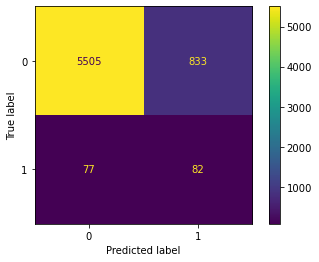

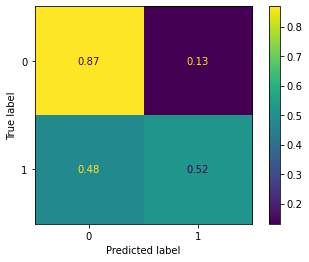

In [27]:
# confusion matrices
evaluate_model(RF_primary_parameters_GS.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

Model performance is a good start. The chart below plots max depth against mean CV F2 score for 4 different numbers of estimators. We can clearly see that 44 is the optimal number of estimators. For larger values, performance drops as tree depth increases. For less estimators, performance improves with greater tree depth but does not reach the best F2 scores achieved by 44 estimator runs.

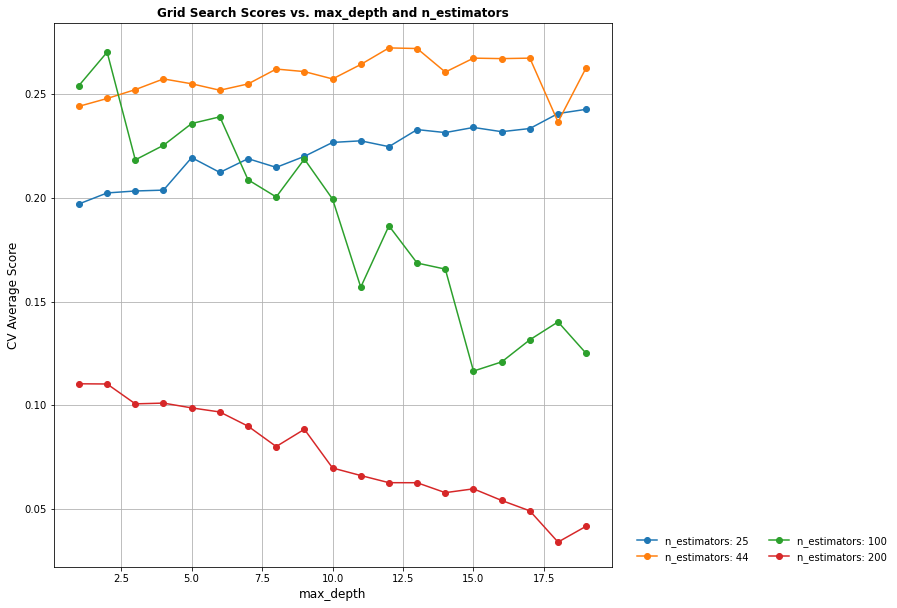

In [28]:
# plot grid search results
plot_grid_search(RF_primary_parameters_GS.cv_results_,list(range(1,20)),[25, 44, 100, 200],'max_depth','n_estimators')

Now I'll grid search the less critical parameters to see if performance can be improved. I'll also include max_depth and n_estimators in the search, but have tightened the range of values based on the results of the above search.

In [29]:
#grid search the less critical parameters and critical parameters closer to optimal zone
param_grid = {'model__n_estimators': [40,44,50], # 44 is estimated optimal
        'model__max_depth' : list(range(3,10)), #7 and 8 were best results previously
        'model__class_weight': ['balanced_subsample'],
        'model__criterion' :['gini', 'entropy'],
        'model__max_features': ['auto', 'sqrt', 'log2']}

RF_secondary_parameters_GS2 = GridSearch_RandomForest(param_grid)

Best: 0.273148 using {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': 9, 'model__max_features': 'sqrt', 'model__n_estimators': 44}


----- EVAL METRICS -----
Precision: 0.0947
Recall: 0.4025
F2: 0.2439


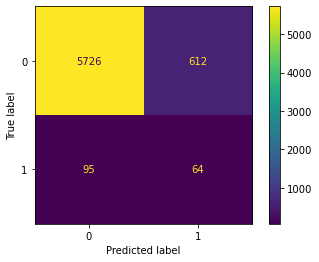

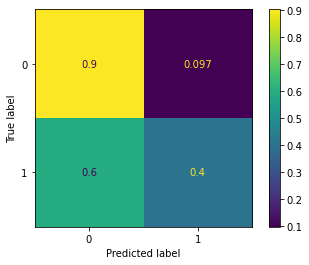

In [30]:
evaluate_model(RF_secondary_parameters_GS2.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

Performance is better on validation set, but we must be careful not to overfit this particular validation set. The mean f2 score from cross validation is also slightly higher.

### Random Forest - with under/oversampling

Now I will see if oversampling/undersampling can improve performance. Recall is currently only ~0.5 and this may be because the model doesn't have enough of the minority class to work with. I'll use a pipeline with SMOTE oversampling and random undersampling via the Imbalanced Learn package.

SMOTE works by selecting K nearest neighbors in the mindority class, draws a "line" between the neighbors in the feature space and then synthesizes a new sample at a random point along that line.
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

I'll try a few different hyperparameter values for the sampling: ratios of over/under sampling as well as k for the SMOTE oversampling. This determines how many real members of the minority class are used to generate each synthesized record. I use the SMOTENC version of SMOTE which is designed to handle categorical features as well as numeric features.

In [31]:
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score

In [32]:
# Random Search CV: random forest pipeline with SMOTE oversampling, undersampling

# parameter grid
param_grid = {'model__n_estimators': list(range(40,55)),
        'model__max_features': ['auto'],
        'model__max_depth' : list(range(6,12)),
        'model__criterion' :['gini'],
        'model__class_weight': ['balanced', 'balanced_subsample'],
       'under__sampling_strategy': [0.5, 0.8],
       'over__sampling_strategy': [0.1, 0.2],
       'over__k_neighbors': [2,5,10]}

# over sample minority class
cat_cols_mask = [True if col in cat_cols else False for col in X_train.columns]
over = SMOTENC(categorical_features=cat_cols_mask)

# under sample majority class
under = RandomUnderSampler()

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = RandomForestClassifier()

# define pipeline
steps = [('over', over), ('under', under), ('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=100,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result_RFss = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result_RFss.best_score_, grid_result_RFss.best_params_))

Best: 0.246326 using {'under__sampling_strategy': 0.8, 'over__sampling_strategy': 0.1, 'over__k_neighbors': 10, 'model__n_estimators': 53, 'model__max_features': 'auto', 'model__max_depth': 11, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}


----- EVAL METRICS -----
Precision: 0.0757
Recall: 0.5031
F2: 0.2363


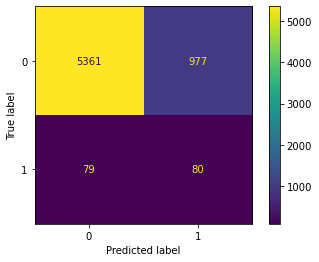

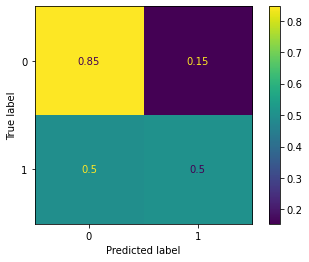

In [33]:
evaluate_model(grid_result_RFss.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

In [34]:
random_forest_SMOTE_results = pd.DataFrame(grid_result_RFss.cv_results_)

In [35]:
#compare results of different hyperparameter combinations
random_forest_SMOTE_results[['mean_test_fbeta','mean_test_Recall', 'param_model__max_depth',
                            'param_model__n_estimators','param_over__k_neighbors']].sort_values('mean_test_fbeta', ascending=False).head(20)

,mean_test_fbeta,mean_test_Recall,param_model__max_depth,param_model__n_estimators,param_over__k_neighbors
75,0.246326,0.521181,11,53,10
11,0.245398,0.557540,10,52,5
20,0.245205,0.450471,11,52,2
4,0.244913,0.588963,9,41,2
13,0.243769,0.516543,11,46,5
0,0.243525,0.530556,9,50,5
57,0.243436,0.533854,10,46,5
90,0.243137,0.566939,9,54,10
12,0.242589,0.489732,10,44,5
15,0.242260,0.527431,10,49,10


Over/under sampling results in increased recall but at the expense of precision/F2. This means that while more large wildfires are being correctly identified, more small wildfires are also being misclassified.

If this model is to provide value to wildland firefighting efforts I don't want it to incorrectly classify too many small fires as large. 

### XGBoost - No Sampling

Now I will try using the Extreme Gradient Boosting algorithm to see if it offers better performance than the standard random forest model. First I'll try with no over/undersampling.

Learning rate, subsample and min child weight = most important hyperparameters
https://blog.dataiku.com/narrowing-the-search-which-hyperparameters-really-matter

In [36]:
# determine ratio of positive to negeative classes in order to estimate optimal value for scale positive weight
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 39.909


In [37]:
from xgboost import XGBClassifier

# parameter grid - these ranges were refined through a few iterations that are not shown here
param_grid = {'model__max_depth':[2,3,4,5,6,7],
              'model__learning_rate':np.arange(0.2, 1.0, 0.1),
              'model__colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'model__subsample':np.arange(0.5, 1.0, 0.1),
              'model__min_child_weight':np.arange(0.1, 2, 0.1),
              'model__scale_pos_weight': np.arange(30,60,5)}

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = XGBClassifier(verbosity = 0)

# define pipeline
steps = [('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = RandomizedSearchCV(estimator=pipeline, n_iter = 100, param_distributions=param_grid,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result_xgb = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result_xgb.best_score_, grid_result_xgb.best_params_))

/Users/allankapoor/opt/anaconda3/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best: 0.274361 using {'model__subsample': 0.7999999999999999, 'model__scale_pos_weight': 35, 'model__min_child_weight': 0.6, 'model__max_depth': 3, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.8999999999999999}


In [38]:
print("Best: %f using %s" % (grid_result_xgb.best_score_, grid_result_xgb.best_params_))

Best: 0.274361 using {'model__subsample': 0.7999999999999999, 'model__scale_pos_weight': 35, 'model__min_child_weight': 0.6, 'model__max_depth': 3, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.8999999999999999}


In [39]:
def get_cv_scores(gr):
    
    '''Print mean CV scores for F2 and Recall from grid result'''

    fbeta = round(gr.cv_results_['mean_test_fbeta'][gr.best_index_],4)
    recall = round(gr.cv_results_['mean_test_Recall'][gr.best_index_],4)
    print(f'F2: {fbeta}')
    print(f'Recall: {recall}')

In [40]:
get_cv_scores(grid_result_xgb)

F2: 0.2744
Recall: 0.5762


/Users/allankapoor/opt/anaconda3/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


----- EVAL METRICS -----
Precision: 0.084
Recall: 0.5346
F2: 0.2579


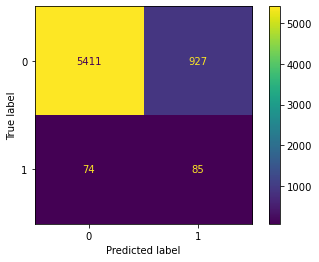

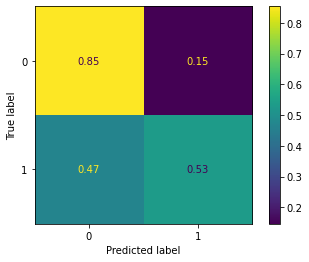

In [41]:
evaluate_model(grid_result_xgb.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

In [42]:
#examine configurations of best peforming models
xgboost_results = pd.DataFrame(grid_result_xgb.cv_results_)
xgboost_results[['mean_test_fbeta',
                 'mean_test_Recall',
                 'param_model__subsample',
                 'param_model__scale_pos_weight',
                 'param_model__max_depth',
                 'param_model__learning_rate',
                 'param_model__colsample_bytree',
                 'param_model__subsample',
                 'param_model__min_child_weight'
                ]].sort_values('mean_test_fbeta', ascending=False).head(20)

,mean_test_fbeta,mean_test_Recall,param_model__subsample,param_model__scale_pos_weight,param_model__max_depth,param_model__learning_rate,param_model__colsample_bytree,param_model__subsample,param_model__min_child_weight
75,0.274361,0.576166,0.8,35,3,0.2,0.9,0.8,0.6
94,0.270584,0.428398,0.8,30,4,0.2,0.6,0.8,1.0
30,0.267381,0.470784,0.9,40,4,0.2,0.9,0.9,1.2
46,0.265779,0.496057,0.8,45,4,0.2,0.7,0.8,0.5
87,0.263203,0.588914,0.8,40,3,0.2,0.9,0.8,0.9
70,0.262426,0.559102,0.5,30,2,0.4,0.9,0.5,0.2
61,0.252565,0.411086,0.7,50,4,0.3,0.7,0.7,0.9
67,0.250257,0.592063,0.6,45,3,0.2,0.9,0.6,1.4
9,0.248947,0.430035,0.9,55,3,0.6,0.9,0.9,1.2
37,0.247221,0.596726,0.8,50,2,0.9,0.5,0.8,1.1


XGBoost is performing close, but slightly worse than the random forest classifier.

### XGBoost - SMOTE Oversampling

Now I'll try XGBoost with under/oversampling. Perhaps the poor performance is due to class imbalance. First I need to think about how changing the class balance will influence the upper/lower bounds of our scale_pos_weight hyperparameter. Because the class imbalance will be less, the scale_pos_weight should be greatly reduced and the range in the grid search should be adjusted accordingly. 

In [43]:
# determine ratio of positive to negative classes in order to estimate scale positive weight
over = SMOTENC(categorical_features=cat_cols_mask, sampling_strategy=0.1)
oversampled_x, oversampled_y = over.fit_resample(X_train_sub, y_train_sub)
under = RandomUnderSampler(sampling_strategy=0.2)

undersampled_x, undersampled_y = under.fit_resample(oversampled_x, oversampled_y)

from collections import Counter
counter = Counter(undersampled_y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 5.000


In [44]:
from xgboost import XGBClassifier

param_grid = {'model__max_depth':[2,3,4],
              'model__learning_rate':[0.2, 0.3, 0.4],
              'model__colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'model__subsample':np.arange(0.5, 1.0, 0.1),
              'model__min_child_weight':np.arange(0.1, 2, 0.1),
              'model__scale_pos_weight': [1, 2, 3, 5, 7],
             'under__sampling_strategy': [0.2, 0.5, 0.8],
              'over__sampling_strategy': [0.1, 0.2, 0.3],
              'over__k_neighbors': [2,5,10]}

# over sample minority class
cat_cols_mask = [True if col in cat_cols else False for col in X_train.columns]
over = SMOTENC(categorical_features=cat_cols_mask)

# under sample majority class
under = RandomUnderSampler()

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = XGBClassifier(use_label_encoder=False)

# define pipeline
steps = [('over',over), ('under', under), ('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = RandomizedSearchCV(estimator=pipeline, n_iter = 100, param_distributions=param_grid,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result_xgbos = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result_xgbos.best_score_, grid_result_xgbos.best_params_))

/Users/allankapoor/opt/anaconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.46463294 0.28660714 0.34957837 0.61743552        nan        nan
        nan 0.38896329 0.45359623 0.28829365 0.47884425 0.58258929
 0.43479663 0.30104167 0.36686508        nan 0.79362599 0.57631448
        nan 0.34171627 0.28320933 0.29618056 0.09134425 0.6125496
 0.54494048 0.65818452 0.28035714 0.55907738 0.22698413 0.09769345
 0.23142361 0.09312996 0.22524802 0.5906746  0.24414683 0.15771329
 0.48023313 0.16542659        nan 0.1875248         nan 0.69444444
 0.33251488 0.30257937 0.23303571 0.30716766 0.62842262 0.79362599
 0.31185516 0.28494544        nan 0.603125   0.15143849 0.3781498
 0.53065476        nan        nan 0.48194444 0.09915675 0.51949405
 0.47710813 0.70230655 0.05193452 0.26292163 0.30260417 0.55897817
 0.52433036 0.61887401 0.36061508 0.30543155 0.73521825 0.26932044
 0.15287698 0.11180556 0.4

Best: 0.253581 using {'under__sampling_strategy': 0.8, 'over__sampling_strategy': 0.1, 'over__k_neighbors': 2, 'model__subsample': 0.6, 'model__scale_pos_weight': 2, 'model__min_child_weight': 1.4000000000000001, 'model__max_depth': 4, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.6}


----- EVAL METRICS -----
Precision: 0.0775
Recall: 0.4969
F2: 0.2385


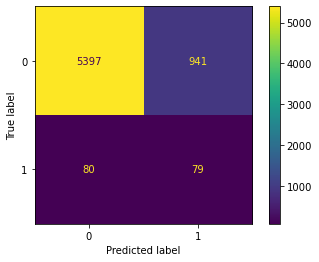

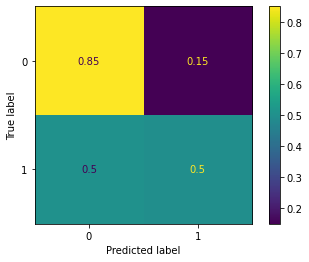

In [45]:
evaluate_model(grid_result_xgbos.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

As with Random Forest, the addition of over/undersampling improves Recall at the expense of F2 (which is my primary evaluation metric). 

XGBoost allows us to see "Feature Importance", the relative degree to which each feature is contributing to the model's decision.

In [46]:
#create sorted dataframe of feature importance
from xgboost import plot_importance
best_model = grid_result_xgbos.best_estimator_.fit(X_train, y_train)
feat_importance = best_model.named_steps['model'].feature_importances_
col_names = best_model.named_steps['encode'].get_feature_names()
pd.DataFrame({'col_name':col_names, 'Importance':feat_importance}).sort_values('Importance', ascending=False)

,col_name,Importance
39,usda_fi2,0.067818
41,usda_fi4,0.061314
40,usda_fi3,0.058055
30,slope,0.043034
7,cat__x0_Urban,0.042773
36,fm100,0.042422
38,usda_fi1,0.041790
29,elevation,0.035793
11,cat__x1_MARINE_W_COAST_FOREST,0.030368
24,cat__x2_S_CA_Mountains,0.030267


Interestingly, the categorical environment fields are contributing the most to the model. Perhaps this is because wildfires located in urban/agricultural areas tend to be closer to roads and are therefore more easily put out before they grow to be too large. Let's compare vs cross tabulation:

In [ ]:
# plot bar chot of cross tabulation between fire size and another category
wfs_train = pd.concat([X_train,y_train], axis=1)
def plot_firesize_comparison(df,column,category):
    flag = df.apply(lambda r: 1 if r[column] == category else 0, axis=1)
    pd.crosstab(df['FIRE_SIZE_CLASS'],flag,normalize='index').plot.bar(stacked=True)
    plt.ylabel('Proportion of Fires')
    plt.xlabel('Fire Size Class')
    plt.legend([f'Non-{category}', category],loc='right')
    plt.title(f'Fire Size vs. {category}')

    plt.show()

In [ ]:
plot_firesize_comparison(wfs_train,'WHR10','Urban')

In [ ]:
plot_firesize_comparison(wfs_train,'WHR10','Agriculture')

As expected, the charts show that wildfires are less likley to be large if they are in Urban or Agricultural areas. 

### Light GBM
XGBoost is not performing as well as I hoped, so I'll try another popular gradient boosting algorithm.

First, with class weighting but no over/undersampling:

In [48]:
%%time
from lightgbm import LGBMClassifier

# parameter grid - these ranges were refined through a few iterations that are not shown here
param_grid = {'model__max_depth':range(3,12),
              'model__num_leaves': np.arange(20, 3000,20),
             'model__n_estimators': np.arange(50,1000,50),
             'model__learning_rate': np.arange(0.01,0.3,0.2),
             'model__lambda_l1':np.arange(1,100,10),
             'model__min_gain_to_split':np.arange(0,15),
             'model__bagging_fraction': np.arange(0.2,0.95, 0.1)}

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = LGBMClassifier(is_unbalance=True)

# define pipeline
steps = [('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = RandomizedSearchCV(estimator=pipeline, n_iter = 100, param_distributions=param_grid,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result_lgb = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result_lgb.best_score_, grid_result_lgb.best_params_))

[LightGBM] [Warning] bagging_fraction is set=0.4000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l1 is set=31, reg_alpha=0.0 will be ignored. Current value: lambda_l1=31
Best: 0.285640 using {'model__num_leaves': 2940, 'model__n_estimators': 700, 'model__min_gain_to_split': 3, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__lambda_l1': 31, 'model__bagging_fraction': 0.4000000000000001}
CPU times: user 20 s, sys: 2.65 s, total: 22.7 s
Wall time: 37min 47s


In [49]:
get_cv_scores(grid_result_lgb)

F2: 0.2856
Recall: 0.4537


----- EVAL METRICS -----
Precision: 0.1033
Recall: 0.4151
F2: 0.2588


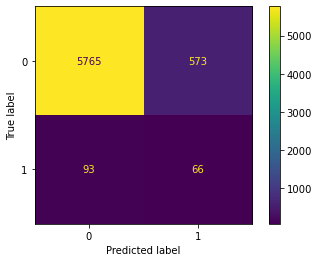

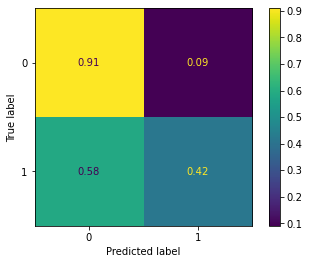

In [50]:
evaluate_model(grid_result_lgb.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

We see an improvement in F2 scores for both the cross-validation and on our validation set (not our test set!) over both random forest and XGBoost.

Now I'll look at the feature importances to see if they are similar to the XGBoost model.

In [51]:
#create sorted dataframe of feature importance
from lightgbm import plot_importance
best_model = grid_result_lgb.best_estimator_.fit(X_train, y_train)
feat_importance = best_model.named_steps['model'].feature_importances_
col_names = best_model.named_steps['encode'].get_feature_names()
lgb_importances = pd.DataFrame({'col_name':col_names, 'Importance':feat_importance}).sort_values('Importance', ascending=False)

[LightGBM] [Warning] bagging_fraction is set=0.4000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l1 is set=31, reg_alpha=0.0 will be ignored. Current value: lambda_l1=31


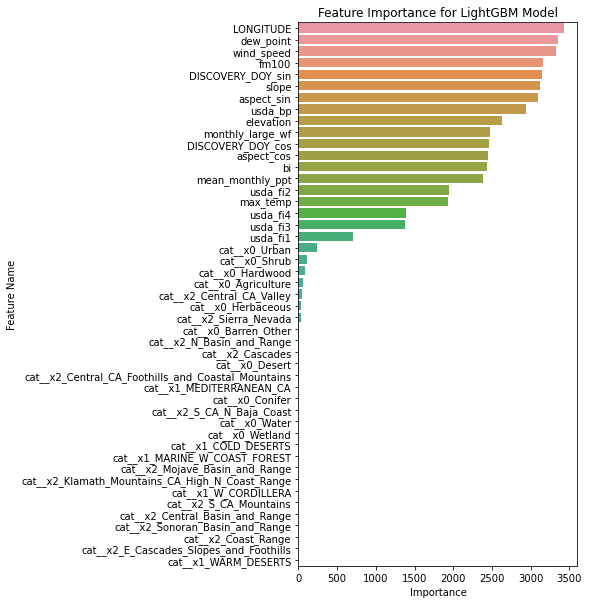

In [52]:
#plot feature importance
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(ax=ax, data=lgb_importances, x='Importance', y="col_name")
ax.set_title('Feature Importance for LightGBM Model')
ax.set_ylabel('Feature Name')
ax.set_xlabel('Importance');

The feature importance chart above looks very different than the  feature importance table for the XGBoost model. While for XGBoost dummy/categorical columns for Agriculture and Urban were most important, here we see that the numeric weather variables from Google Earth Engine are much more prominent.

This much more in line with what we would expect based on background knowledge of factors influencing wildfire severity. Perhaps this is why performance has improved over XGBoost.

### LightGBM with Over/UnderSampling

As with the other models, I'll try LightGBM with SMOTE oversampling/random undersampling

In [53]:
%%time
from lightgbm import LGBMClassifier

# parameter grid - these ranges were refined throgh a few iterations that are not shown here
param_grid = {'model__max_depth':range(3,12),
              'model__num_leaves': np.arange(20, 3000,20),
             'model__n_estimators': np.arange(50,1000,50),
             'model__learning_rate': np.arange(0.01,0.3,0.2),
             'model__lambda_l1':np.arange(1,100,10),
             'model__min_gain_to_split':np.arange(0,15),
             'model__bagging_fraction': np.arange(0.2,0.95, 0.1),
             'under__sampling_strategy': np.arange(0.2,0.98, 0.2),
             'over__sampling_strategy': [0.1, 0.2, 0.3],
             'over__k_neighbors': [2,5,10]}

# over sample minority class
cat_cols_mask = [True if col in cat_cols else False for col in X_train.columns]
over = SMOTENC(categorical_features=cat_cols_mask)

# under sample majority class
under = RandomUnderSampler()

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = LGBMClassifier(is_unbalance=True)

# define pipeline
steps = [('over',over), ('under', under), ('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = RandomizedSearchCV(estimator=pipeline, n_iter = 100, param_distributions=param_grid,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result_lgb_os = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result_lgb_os.best_score_, grid_result_lgb_os.best_params_))

/Users/allankapoor/opt/anaconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.27256944 0.25183532 0.51478175 0.5827629  0.30734127
 0.40654762 0.01572421 0.36842758 0.43638393 0.32601687 0.35925099
        nan 0.30714286 0.28048115        nan 0.54665179 0.29300595
 0.5639881  0.30892857 0.44565972 0.22683532 0.47571925 0.31676587
        nan 0.40488591        nan 0.53546627 0.41733631 0.42217262
 0.3781002  0.26314484 0.40017361 0.33085317 0.3859375  0.30414187
 0.36388889 0.34186508 0.31842758 0.47095734 0.1968254  0.20962302
 0.43630952 0.5624752  0.41116071 0.49310516 0.5639881  0.34186508
 0.44568452 0.47418155 0.49610615 0.36857639 0.15277778        nan
 0.35451389        nan        nan 0.32460317 0.51979167 0.49771825
        nan 0.33095238 0.34506448 0.1812252         nan 0.50714286
 0.40478671 0.42688492 0.3828621  0.24087302 0.36240079 0.36857639
        nan 0.30882937 0

Best: 0.258701 using {'under__sampling_strategy': 0.4, 'over__sampling_strategy': 0.1, 'over__k_neighbors': 5, 'model__num_leaves': 2700, 'model__n_estimators': 950, 'model__min_gain_to_split': 3, 'model__max_depth': 4, 'model__learning_rate': 0.01, 'model__lambda_l1': 21, 'model__bagging_fraction': 0.9000000000000001}
CPU times: user 11.1 s, sys: 1.77 s, total: 12.9 s
Wall time: 26min 42s


In [54]:
get_cv_scores(grid_result_lgb_os)

F2: 0.2587
Recall: 0.5039


----- EVAL METRICS -----
Precision: 0.089
Recall: 0.4843
F2: 0.2565


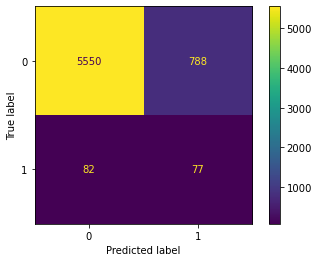

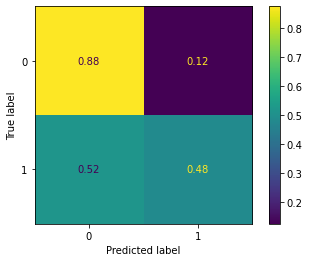

In [55]:
evaluate_model(grid_result_lgb_os.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

Performance is not as good as the LightGBM model without overundersampling.

For all three algorithms, the addition of under/oversampling has negatively impacted performance (although for some the recall was improved). This is counter to most information available online which suggests that oversampling improves model performance for imbalanced classification. Perhaps in this instance the SMOTE method is creating syntheic records of wildfires that wouldn't actually exist in reality and therefore a model trained on these is preforming worse when encountering unseen (real) data.

### Hyperparameter Tuning of LightGBM with Optuna

Of all the algorithms/pipelines I have tried, LightGBM (class weighted, no over/undersampling) is performing the best. Now I'll try to optimize the hyperparameters as much as possible using Optuna (rather than RandomSearchCV).

Credit: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

In [56]:
#dummy encode categorical variables for train and validation set (since we will not use an Sklearn pipeline here)
# train (subset) and validation sets
X_train_sub_dummies = pd.get_dummies(X_train_sub, columns=['WHR10','L2','L3'], drop_first=True)
X_val_dummies = pd.get_dummies(X_val, columns=['WHR10','L2','L3'], drop_first=True)

# full train and test sets (for final model)
X_train_dummies = pd.get_dummies(X_train, columns=['WHR10','L2','L3'], drop_first=True)
X_test_dummies = pd.get_dummies(X_test, columns=['WHR10','L2','L3'], drop_first=True)

In [113]:
# modified evaluate model function to handle optuna outputs
def evaluate_model_lgb(best_params, X_t, y_t, X_v, y_v):
    
    '''Fit model to traing data, predict and evaluate based on validation data, and produce confusion matrices. '''
        
    # fit model to training data
    lgb = LGBMClassifier(is_unbalance=True, **best_params)
    lgb.fit(X_t,y_t)

    # predict on validation set
    y_pred = lgb.predict(X_v)

    # calculate other evaluation metrics
    precision = round(precision_score(y_v, y_pred),4)
    recall = round(recall_score(y_v, y_pred),4)
    f2 = round(fbeta_score(y_v, y_pred, beta=2),4)
    auc = round(roc_auc_score(y_v, y_pred),4)
    
    #plot confusion matrix (on validation data)
    plot_confusion_matrix(lgb, X_v, y_v, labels=None, sample_weight=None, normalize=None);
    
    #plot confusion matrix (on validation data)
    plot_confusion_matrix(lgb, X_v, y_v, labels=None, sample_weight=None, normalize='true');

    # print evaluation metrics
    print('----- EVAL METRICS -----')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F2: {f2}')
    print(f'ROC AUC: {auc}')

In [58]:
import optuna
import warnings

# suppress log messages
warnings.filterwarnings("ignore")

# define scoring
f2_scorer = make_scorer(fbeta_score, beta=2)

# define objective for optuna study
def objective(trial):
    
    # parameter grid with ranges
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),}
    
    #instantiate model
    lgb = LGBMClassifier(is_unbalance=True, **param_grid)
    
    #cross validation with 10 folds
    return cross_val_score(lgb, X_train_sub_dummies, y_train_sub, n_jobs=-1, cv=10,scoring=f2_scorer).mean()

### Red text below is NOT an error. Optuna is printing the results of each trial.

In [59]:
%%time
# optuna hyperparemter optimization study with 200 trials
study = optuna.create_study(direction='maximize', study_name="LGBM Classifier 1")
study.optimize(objective, n_trials=200)

[I 2021-10-11 23:19:33,148] A new study created in memory with name: LGBM Classifier 1
[I 2021-10-11 23:19:36,455] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.0727109753119416, 'num_leaves': 600, 'max_depth': 7, 'min_data_in_leaf': 9900, 'lambda_l1': 60, 'lambda_l2': 80, 'min_gain_to_split': 9.484547377248647, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.0.
[I 2021-10-11 23:19:40,674] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 350, 'learning_rate': 0.18026670425216815, 'num_leaves': 1720, 'max_depth': 11, 'min_data_in_leaf': 9800, 'lambda_l1': 100, 'lambda_l2': 65, 'min_gain_to_split': 5.798500757460975, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.0.
[I 2021-10-11 23:19:47,461] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 700, 'learning_rate': 0.1288691188188

[I 2021-10-11 23:22:43,067] Trial 20 finished with value: 0.21832843553037073 and parameters: {'n_estimators': 450, 'learning_rate': 0.1528774774529525, 'num_leaves': 1440, 'max_depth': 12, 'min_data_in_leaf': 5600, 'lambda_l1': 70, 'lambda_l2': 35, 'min_gain_to_split': 6.600860813502545, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 17 with value: 0.28035291172438837.
[I 2021-10-11 23:22:56,806] Trial 21 finished with value: 0.26802485959591105 and parameters: {'n_estimators': 550, 'learning_rate': 0.13164184291419226, 'num_leaves': 1140, 'max_depth': 8, 'min_data_in_leaf': 300, 'lambda_l1': 70, 'lambda_l2': 50, 'min_gain_to_split': 11.62726892253556, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 17 with value: 0.28035291172438837.
[I 2021-10-11 23:23:10,981] Trial 22 finished with value: 0.26662407449399134 and parameters: {'n_estimators': 550, 'learning_rate': 0.0943557993790857

[I 2021-10-11 23:26:21,421] Trial 40 finished with value: 0.25128105202447465 and parameters: {'n_estimators': 100, 'learning_rate': 0.1964911294862116, 'num_leaves': 600, 'max_depth': 11, 'min_data_in_leaf': 1200, 'lambda_l1': 15, 'lambda_l2': 75, 'min_gain_to_split': 12.957546056944452, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 36 with value: 0.28205544435439156.
[I 2021-10-11 23:26:35,703] Trial 41 finished with value: 0.27713747598993665 and parameters: {'n_estimators': 400, 'learning_rate': 0.1206627738185834, 'num_leaves': 380, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 0, 'lambda_l2': 65, 'min_gain_to_split': 10.105994185806981, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 36 with value: 0.28205544435439156.
[I 2021-10-11 23:26:45,415] Trial 42 finished with value: 0.26453076774904083 and parameters: {'n_estimators': 400, 'learning_rate': 0.13864242340873648, 'num_leaves': 

[I 2021-10-11 23:30:21,489] Trial 60 finished with value: 0.2706399966126326 and parameters: {'n_estimators': 600, 'learning_rate': 0.05600810986286435, 'num_leaves': 700, 'max_depth': 9, 'min_data_in_leaf': 1200, 'lambda_l1': 20, 'lambda_l2': 75, 'min_gain_to_split': 8.601857957437469, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 58 with value: 0.2865766074909201.
[I 2021-10-11 23:30:42,409] Trial 61 finished with value: 0.2701144852343119 and parameters: {'n_estimators': 450, 'learning_rate': 0.030389973102272497, 'num_leaves': 120, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 5, 'lambda_l2': 85, 'min_gain_to_split': 7.961147019164015, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 58 with value: 0.2865766074909201.
[I 2021-10-11 23:31:00,655] Trial 62 finished with value: 0.27955726808752096 and parameters: {'n_estimators': 500, 'learning_rate': 0.08522535998805589, 'num_leaves': 480,

[I 2021-10-11 23:36:26,648] Trial 80 finished with value: 0.2562267013448654 and parameters: {'n_estimators': 400, 'learning_rate': 0.05302765986818025, 'num_leaves': 80, 'max_depth': 10, 'min_data_in_leaf': 1900, 'lambda_l1': 25, 'lambda_l2': 50, 'min_gain_to_split': 7.62623964897185, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 70 with value: 0.28713021740283795.
[I 2021-10-11 23:36:52,923] Trial 81 finished with value: 0.2804773743535057 and parameters: {'n_estimators': 550, 'learning_rate': 0.029788639087989136, 'num_leaves': 140, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 35, 'lambda_l2': 60, 'min_gain_to_split': 8.613536652329671, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 70 with value: 0.28713021740283795.
[I 2021-10-11 23:37:14,493] Trial 82 finished with value: 0.26733587895193855 and parameters: {'n_estimators': 500, 'learning_rate': 0.025407589890029048, 'num_leaves': 2320, 'max_depth

[I 2021-10-11 23:45:34,035] Trial 100 finished with value: 0.2715074254553852 and parameters: {'n_estimators': 1000, 'learning_rate': 0.04999320454715431, 'num_leaves': 420, 'max_depth': 11, 'min_data_in_leaf': 2200, 'lambda_l1': 20, 'lambda_l2': 65, 'min_gain_to_split': 3.2006183066559304, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 98 with value: 0.2877285196620496.
[I 2021-10-11 23:46:22,531] Trial 101 finished with value: 0.2589393567100438 and parameters: {'n_estimators': 900, 'learning_rate': 0.06585610865508788, 'num_leaves': 300, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 15, 'lambda_l2': 70, 'min_gain_to_split': 0.6593376694475506, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 98 with value: 0.2877285196620496.
[I 2021-10-11 23:46:51,849] Trial 102 finished with value: 0.2785621707999148 and parameters: {'n_estimators': 950, 'learning_rate': 0.06680685406143547, 'num_leaves': 540, 'max_de

[I 2021-10-11 23:58:57,334] Trial 120 finished with value: 0.28725992311687965 and parameters: {'n_estimators': 950, 'learning_rate': 0.029890042556904382, 'num_leaves': 540, 'max_depth': 11, 'min_data_in_leaf': 900, 'lambda_l1': 25, 'lambda_l2': 100, 'min_gain_to_split': 2.6405222963294657, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 110 with value: 0.29189382468367364.
[I 2021-10-11 23:59:24,606] Trial 121 finished with value: 0.2735932861972426 and parameters: {'n_estimators': 950, 'learning_rate': 0.03349356853980483, 'num_leaves': 520, 'max_depth': 4, 'min_data_in_leaf': 1000, 'lambda_l1': 25, 'lambda_l2': 100, 'min_gain_to_split': 3.509407838074006, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 110 with value: 0.29189382468367364.
[I 2021-10-12 00:00:13,144] Trial 122 finished with value: 0.2878447104660333 and parameters: {'n_estimators': 950, 'learning_rate': 0.027087105652505782, 'num_leaves': 420, '

[I 2021-10-12 00:16:26,843] Trial 140 finished with value: 0.27463825564698147 and parameters: {'n_estimators': 950, 'learning_rate': 0.02065124507850032, 'num_leaves': 300, 'max_depth': 11, 'min_data_in_leaf': 700, 'lambda_l1': 50, 'lambda_l2': 95, 'min_gain_to_split': 2.10868076964142, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 133 with value: 0.29591988295370547.
[I 2021-10-12 00:17:10,820] Trial 141 finished with value: 0.28826147389438966 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03165977646303847, 'num_leaves': 140, 'max_depth': 11, 'min_data_in_leaf': 900, 'lambda_l1': 35, 'lambda_l2': 95, 'min_gain_to_split': 1.7200177835472026, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 133 with value: 0.29591988295370547.
[I 2021-10-12 00:18:04,253] Trial 142 finished with value: 0.29598552311583354 and parameters: {'n_estimators': 1000, 'learning_rate': 0.029851024392091974, 'num_leaves': 140, '

[I 2021-10-12 00:32:38,869] Trial 160 finished with value: 0.30111212435388457 and parameters: {'n_estimators': 850, 'learning_rate': 0.03305610543440238, 'num_leaves': 200, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 50, 'lambda_l2': 95, 'min_gain_to_split': 0.28629002456311925, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 147 with value: 0.3020338140312329.
[I 2021-10-12 00:33:40,047] Trial 161 finished with value: 0.2953120943303755 and parameters: {'n_estimators': 900, 'learning_rate': 0.03332793001303819, 'num_leaves': 180, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 50, 'lambda_l2': 95, 'min_gain_to_split': 0.36466998680261914, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 147 with value: 0.3020338140312329.
[I 2021-10-12 00:34:17,891] Trial 162 finished with value: 0.2840893394683396 and parameters: {'n_estimators': 850, 'learning_rate': 0.03354264950194338, 'num_leaves': 220, 'max

[I 2021-10-12 00:50:03,715] Trial 180 finished with value: 0.28213692179710415 and parameters: {'n_estimators': 750, 'learning_rate': 0.039295620209079674, 'num_leaves': 120, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 65, 'lambda_l2': 100, 'min_gain_to_split': 0.7648629883053435, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 147 with value: 0.3020338140312329.
[I 2021-10-12 00:51:10,951] Trial 181 finished with value: 0.30480910140171164 and parameters: {'n_estimators': 850, 'learning_rate': 0.03704841334017169, 'num_leaves': 200, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 50, 'lambda_l2': 100, 'min_gain_to_split': 0.3217655057990588, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 181 with value: 0.30480910140171164.
[I 2021-10-12 00:51:40,613] Trial 182 finished with value: 0.24470092471309654 and parameters: {'n_estimators': 850, 'learning_rate': 0.25292279036804594, 'num_leaves': 200, 

CPU times: user 8.82 s, sys: 2.58 s, total: 11.4 s
Wall time: 1h 43min 33s


In [60]:
# get results/settings from best trial
trial_1_best = study.best_trial
print('F2: {}'.format(trial_1_best.value))
print("Best hyperparameters: {}".format(trial_1_best.params))
trial_1_best_params = study.best_params

F2: 0.30480910140171164
Best hyperparameters: {'n_estimators': 850, 'learning_rate': 0.03704841334017169, 'num_leaves': 200, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 50, 'lambda_l2': 100, 'min_gain_to_split': 0.3217655057990588, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3217655057990588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3217655057990588
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
----- EVAL METRICS -----
Precision: 0.1189
Recall: 0.4277
F2: 0.2815


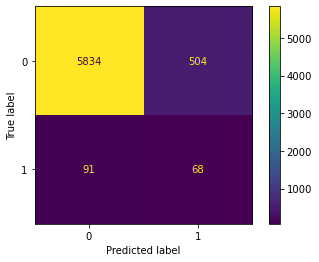

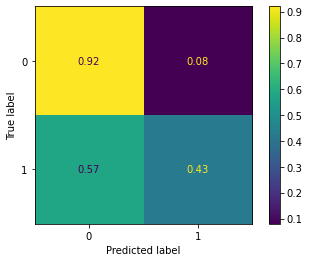

In [61]:
#evaulate model trained on best settings
evaluate_model_lgb(trial_1_best_params, X_train_sub_dummies, y_train_sub, X_val_dummies, y_val)

After hyperparameter tuning with optuna, the LightGBM model performs even better than before. This is the best performing model by far, so we will move forward with it. But first, let's see the feature importances in the model:

In [ ]:
type(pipeline)

In [62]:
lgbm = LGBMClassifier(is_unbalance=True, **trial_1_best_params)

scale=MinMaxScaler()
X_train_dummies_scaled = scale.fit_transform(X_train_dummies)
X_test_dummies_scaled = scale.transform(X_test_dummies)

result_lgbm = lgbm.fit(X_train_dummies_scaled,y_train)

feat_importance = result_lgbm.feature_importances_
col_names = X_train_dummies.columns
lgbm_importances = pd.DataFrame({'col_name':col_names, 'Importance':feat_importance}).sort_values('Importance', ascending=False)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3217655057990588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3217655057990588
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


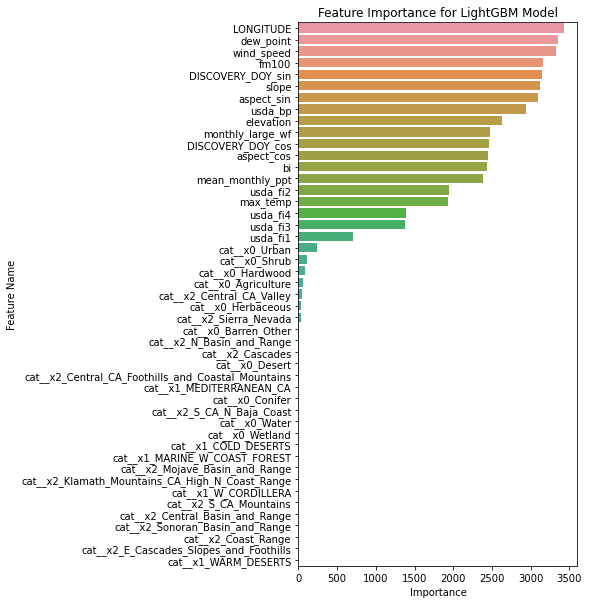

In [63]:
#plot feature importance
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(ax=ax, data=lgb_importances, x='Importance', y="col_name")
ax.set_title('Feature Importance for LightGBM Model')
ax.set_ylabel('Feature Name')
ax.set_xlabel('Importance');

Feature importances are similar to the first LightGBM model.

# Model Evaluation

In [78]:
# collect best estimators
LR = pipeline_lg1 #
RF = RF_secondary_parameters_GS2.best_estimator_
RF_SMOTE = grid_result_RFss.best_estimator_
XGB = grid_result_xgb.best_estimator_
XGB_SMOTE = grid_result_xgbos.best_estimator_
LGBM = grid_result_lgb.best_estimator_
LGBM_SMOTE = grid_result_lgb_os.best_estimator_

# LGBM_Optuna classifier into pipeline
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )
lgbm = LGBMClassifier(is_unbalance=True, **trial_1_best_params)
steps = [('encode', encode), ('model', lgbm)]
LGBM_Optuna = Pipeline(steps=steps)

In [82]:
#dict of models to evaluate
estimator_list = [LR, RF, RF_SMOTE, XGB, XGB_SMOTE, LGBM, LGBM_SMOTE, LGBM_Optuna]
estimator_names = ['LR', 'RF', 'RF_SMOTE', 'XGB', 'XGB_SMOTE', 'LGBM', 'LGBM_SMOTE', 'LGBM_Optuna']
estimators = dict(zip(estimator_names,estimator_list))

In [83]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_roc_curve

cv_scoring = {'fbeta': make_scorer(fbeta_score, beta=2),'recall': make_scorer(recall_score), 'auc': make_scorer(roc_auc_score)}

estimator_results = {}

for name, estimator in estimators.items():

    #cross validation
    cv_results = cross_validate(estimator, X=X_train_sub, y=y_train_sub, scoring=cv_scoring, cv=10, n_jobs=-1, fit_params=None)

    #get mean cv scores
    f2_mean = np.mean(cv_results['test_fbeta'])
    recall_mean = np.mean(cv_results['test_recall'])
    auc_mean = np.mean(cv_results['test_auc'])

    # fit 
    estimator.fit(X_train_sub,y_train_sub)

    # predict
    y_pred = estimator.predict(X_val)

    #get validation scores
    f2_val = fbeta_score(y_val, y_pred, beta=2)
    recall_val = recall_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_pred)

    #print results
    print(f'<<<<< {name} >>>>>')
    print('----- CV MEAN -----')
    print(f'F2: {f2_mean}')
    print(f'Recall: {recall_mean}')
    print(f'AUC: {auc_mean}')

    print('----- VALIDATION -----')
    print(f'F2: {f2_val}')
    print(f'Recall: {recall_val}')
    print(f'AUC: {auc_val}')
    
    #save results
    estimator_results[name] = [f2_mean, recall_mean, auc_mean, f2_val, recall_val, auc_val]


<<<<< LR >>>>>
----- CV MEAN -----
F2: 0.23190605062951644
Recall: 0.748189484126984
AUC: 0.7314911917676341
----- VALIDATION -----
F2: 0.2431372549019608
Recall: 0.779874213836478
AUC: 0.7487253681994003
<<<<< RF >>>>>
----- CV MEAN -----
F2: 0.255258468818664
Recall: 0.41294642857142855
AUC: 0.6605166067906454
----- VALIDATION -----
F2: 0.2677224736048265
Recall: 0.44654088050314467
AUC: 0.6744380009962868
<<<<< RF_SMOTE >>>>>
----- CV MEAN -----
F2: 0.23994286888616476
Recall: 0.5073908730158729
AUC: 0.6779163438057668
----- VALIDATION -----
F2: 0.23393461104847801
Recall: 0.5220125786163522
AUC: 0.6777781416275198
<<<<< XGB >>>>>
----- CV MEAN -----
F2: 0.26000703915271794
Recall: 0.5497023809523809
AUC: 0.6994665750915751
----- VALIDATION -----
F2: 0.25788834951456313
Recall: 0.5345911949685535
AUC: 0.6941652724606099
<<<<< XGB_SMOTE >>>>>
----- CV MEAN -----
F2: 0.23913640756633217
Recall: 0.49308035714285714
AUC: 0.6738577328120597
----- VALIDATION -----
F2: 0.24907749077490773


In [107]:
#dataframe of estimator results
estimator_results_cols = ['f2 CV Mean', 'recall CV mean', 'roc auc CV mean',
                          'f2 validation', 'recall validation', 'roc auc validation']
estimator_results_df = pd.DataFrame.from_dict(estimator_results, orient='index', columns=estimator_results_cols)
estimator_results_df = estimator_results_df.sort_values('f2 CV Mean', ascending=False)
estimator_results_df = round(estimator_results_df,3)
estimator_results_df.to_csv('estimator_results_df.csv')
estimator_results_df

,f2 CV Mean,recall CV mean,roc auc CV mean,f2 validation,recall validation,roc auc validation
LGBM_Optuna,0.296,0.457,0.688,0.287,0.434,0.678
LGBM,0.280,0.447,0.680,0.259,0.415,0.662
XGB,0.260,0.550,0.699,0.258,0.535,0.694
RF,0.255,0.413,0.661,0.268,0.447,0.674
LGBM_SMOTE,0.248,0.476,0.674,0.243,0.440,0.662
RF_SMOTE,0.240,0.507,0.678,0.234,0.522,0.678
XGB_SMOTE,0.239,0.493,0.674,0.249,0.509,0.683
LR,0.232,0.748,0.731,0.243,0.780,0.749


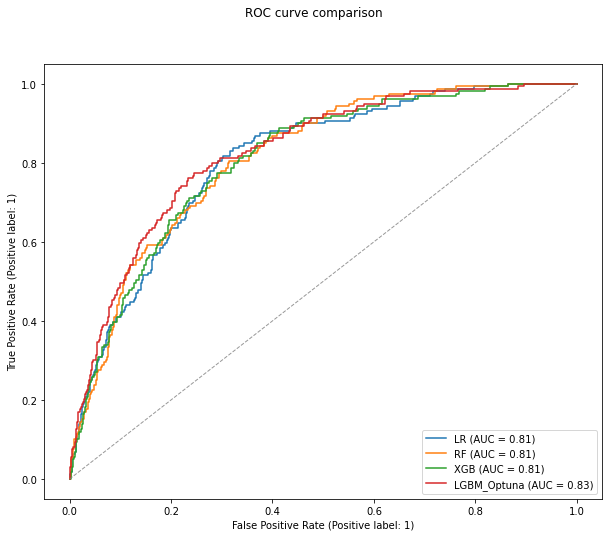

In [106]:
#dict of models to evaluate
estimator_list_plot = [LR, RF, XGB, LGBM_Optuna]
estimator_names_plot = ['LR', 'RF', 'XGB', 'LGBM_Optuna']
estimators_plot = dict(zip(estimator_names_plot,estimator_list_plot))

#plot roc curves
fig, ax = plt.subplots(ncols=1, figsize=(10,8))

for name,estimator in estimators_plot.items():

    fig = plot_roc_curve(estimator, X_val, y_val, name=name, ax=ax)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey',
        label='Chance', alpha=.8)

fig.figure_.suptitle("ROC curve comparison")
plt.show()

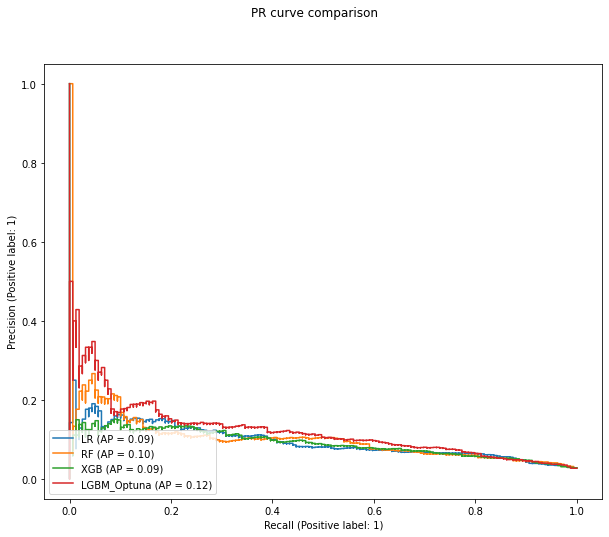

In [104]:
#plot pr curves
from sklearn.metrics import plot_precision_recall_curve
fig, ax = plt.subplots(ncols=1, figsize=(10,8))

for name,estimator in estimators_plot.items():

    fig = plot_precision_recall_curve(estimator, X_val, y_val, name=name, ax=ax)

fig.figure_.suptitle("PR curve comparison")
plt.show()

# Final Model Training and Evaluation

Now that I have selected our best performing model (based on f2 scores from 10-fold cross validation) I train it on the full training set and evaluate performance on the hold-out test set that has not previously been used.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3217655057990588, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3217655057990588
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
----- EVAL METRICS -----
Precision: 0.1206
Recall: 0.4673
F2: 0.2967
ROC AUC: 0.6909


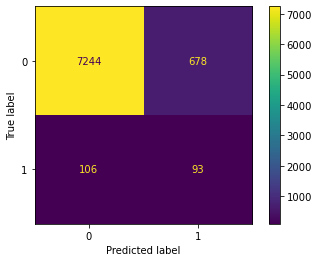

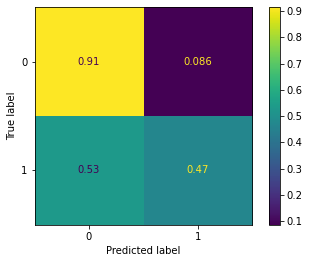

In [114]:
#evaulate model trained on best settings
evaluate_model_lgb(trial_1_best_params, X_train_dummies, y_train, X_test_dummies, y_test)

In [120]:
round(pd.DataFrame.from_dict(trial_1_best_params, orient='index'),3)

,0
n_estimators,850.000
learning_rate,0.037
num_leaves,200.000
max_depth,12.000
min_data_in_leaf,200.000
lambda_l1,50.000
lambda_l2,100.000
min_gain_to_split,0.322
bagging_fraction,0.800
bagging_freq,1.000


In [124]:
#cross validation
cv_results = cross_validate(pipeline_dummy, X=X_train_sub, y=y_train_sub, scoring=cv_scoring, cv=10, n_jobs=-1, fit_params=None)

#get mean cv scores
f2_mean = np.mean(cv_results['test_fbeta'])
recall_mean = np.mean(cv_results['test_recall'])
auc_mean = np.mean(cv_results['test_auc'])

# fit 
pipeline_dummy.fit(X_train_sub,y_train_sub)

# predict
y_pred = pipeline_dummy.predict(X_val)

#get validation scores
f2_val = fbeta_score(y_val, y_pred, beta=2)
recall_val = recall_score(y_val, y_pred)
auc_val = roc_auc_score(y_val, y_pred)

#print results
print(f'<<<<< DUMMY >>>>>')
print('----- CV MEAN -----')
print(f'F2: {f2_mean}')
print(f'Recall: {recall_mean}')
print(f'AUC: {auc_mean}')

print('----- VALIDATION -----')
print(f'F2: {f2_val}')
print(f'Recall: {recall_val}')
print(f'AUC: {auc_val}')


<<<<< DUMMY >>>>>
----- CV MEAN -----
F2: 0.02524032521341162
Recall: 0.025148809523809525
AUC: 0.5007400852352776
----- VALIDATION -----
F2: 0.018541409147095178
Recall: 0.018867924528301886
AUC: 0.49602279154783663
